In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter('ignore')

In [2]:
import requests

open_change_rates_id = "bdaafee9084443c9b911a29bd9a78bb1"

In [3]:
pd.set_option("display.max_colwidth",200)
pd.options.display.float_format = '{:,.2f}'.format

# Thành viên nhóm
| Họ và tên      | MSSV |
| ----------- | ----------- |
| Lê Anh Vũ| 19120724|
| Nguyễn Phú Thụ| 19120673|


# 1. Movies dataset

## 1. Mô tả dữ liệu: Dữ liệu mô tả các bộ phim nổi tiếng nhất từ 2003-2022
- Tập dữ liệu mô tả các thông tin về bộ phim như: thể loại, đạo diện sản xuất, dàn diễn viên, thời gian khởi chiếu, v.v
- Tập dữ liệu cũng cho biết các thông tin về doanh thu như: số vốn đầu tư và doanh thu

Ý nghĩa các trường thuộc tính trong dataset:

| Syntax      | Description |
| ----------- | ----------- |
| Title      | Tên phim       |
| Rating   | điểm đánh giá phim dựa theo iMDB        |
| Year      | Năm khởi chiếu       |
| Month   | Tháng khởi chiếu        |
| Certificate      | Chứng chỉ film       |
| Runtime   | Thời lượng phim        |
| Directors      | Đạo diễn       |
| Stars   | Diễn viên trong film        |
| Genre      | Thể loại       |
| Filming_location   | Địa điểm phim quay hình        |
| Country_of_origin   | Quốc gia tham gia sản xuất        |
| Budget | Chi phí bộ phim|
| Income | Doanh thu của bộ phim |


**Dữ liệu được update lần cuối trên kaggle là 02/03/2023. Thông tin chi tiết [tại đây](https://www.kaggle.com/datasets/georgescutelnicu/top-100-popular-movies-from-2003-to-2022-imdb?select=movies.csv)**

# 2. Bài toán
- Dự đoán doanh thu của một bộ phim dựa trên các thông tin như tiêu đề, điểm đánh giá, năm khởi chiếu, tháng khởi chiếu, chứng chỉ, thời lượng, đạo diễn, diễn viên, thể loại, địa điểm quay, quốc gia sản xuất, chi phí sản xuất

**Bài toán**
Dự đoán doanh thu của một bộ phim dựa trên các thông tin như tiêu đề, điểm đánh giá, năm khởi chiếu, tháng khởi chiếu, chứng chỉ, thời lượng, đạo diễn, diễn viên, thể loại, địa điểm quay, quốc gia sản xuất, chi phí sản xuất

**Giả thuyết**
- Giả thuyết 1: Tiêu đề phim và điểm đánh giá phim có tác động lớn đến doanh thu của phim.
- Giả thuyết 2: Phim được sản xuất ở các quốc gia phát triển sẽ có doanh thu cao hơn so với các quốc gia đang phát triển.
- Giả thuyết 3: Chi phí sản xuất phim sẽ ảnh hưởng đến doanh thu của phim.
- Giả thuyết 4: Đạo diễn và diễn viên nổi tiếng sẽ khiến khán giả đi xem phim nhiều hơn. 

**Chọn giả thuyết và giải thích**

Nhóm sẽ chọn giả thuyết 1 vì tiêu đề phim và điểm đánh giá phim là những yếu tố quan trọng mà khán giả sẽ xem xét trước khi quyết định xem phim hay không. 

Nhất là điểm đánh giá, khi một khán giả quyết định xem một bộ phim hay không, nhất là khi phim mới ra mắt, họ rất cần một chỉ số đánh giá phim để tin tưởng và quyết định bỏ tiền để xem bộ phim đó. Nếu điểm đánh giá cao thì thông thường chúng ta nghĩ rằng bộ phim đó sẽ hay hơn mức trung bình, sẽ gây hiệu ứng cho đám đông.

Ngoài ra tên phim cũng là một yếu tố khi đó là thứ mà khán giả thấy đầu tiên. Tiêu đề cũng tạo ra các ấn tượng ban đầu và gợi ý về nội dung của phim. Nếu tiêu đề hấp dẫn, thì nó sẽ thu hút khản giả và tạo ra sự tò mò. Ngược lại nó sẽ khiến khán gỉa không quan tâm đến bộ phim. Nếu tiêu đề phù hợp với sở thích và giá trị của một tập thể, họ có xu hướng quan tâm đến bộ phim đó hơn.

# 3. Thiết kế mô hình

Dựa vào bài viết [Six steps to build a machine learning model](https://www.seldon.io/how-to-build-a-machine-learning-model). Nhóm sẽ thực hiện các bước sau.
- **Contextualise machine learning**: Định nghĩa bài toán, mục tiêu cần đạt được, cách triển khai và quản lí.  
- **Explore the data and choose the type of algorithm**: Bước tiếp theo là khám phá dữ liệu và chọn thuật toán phù hợp. Các loại thuật toán  bao gồm học có giám sát, học không giám sát và học tăng cường.
- **Prepare and clean the dataset**: Trước khi có thể đào tạo mô hình, tập dữ liệu phải được chuẩn bị và làm sạch. Điều này bao gồm xử lý dữ liệu bị thiếu, dữ liệu nhiễu và dữ liệu không chính xác.
- **Split the prepared dataset and perform cross validation**: Tập dữ liệu đã được chuẩn bị phải được chia thành tập huấn luyện và tập kiểm tra. Cross validation được sử dụng để đánh giá hiệu suất của mô hình trên tập kiểm tra.  
- **Perform machine learning optimisation**:  Mô hình cần được tinh chỉnh và cải thiện để đạt được hiệu suất tốt nhất. Điều này bao gồm tối ưu hóa các siêu tham số của mô hình. 
- **Deploy the model**: Cuối cùng, mô hình cần được triển khai để được sử dụng trong các ứng dụng thực tế 

# 4. EDA

EDA mục đích để khám phá dữ liệu và dựa vào bài toán để lựa chọn loại học máy hợp lý.

Ở bước này, nhóm sẽ thực hiện:
- Hiểu rõ hơn về tính chất của dữ liệu, bao gồm các đặc điểm thống kê như mean, median, mode, range, variance, skewness, kurtosis, ...

- Phát hiện các giá trị bất thường hoặc thiếu sót trong dữ liệu.

- Tìm kiếm mối quan hệ giữa các biến trong dữ liệu.

- Phân tích phân bố và tương quan của các biến đối với nhau.

- Trực quan hóa dữ liệu để giúp bạn dễ dàng hình dung và hiểu rõ hơn về dữ liệu của mình.

In [4]:
movie_df = pd.read_csv('movies.csv')
movie_df.head(2)

,Title,Rating,Year,Month,Certificate,Runtime,Directors,Stars,Genre,Filming_location,Budget,Income,Country_of_origin
0,Avatar: The Way of Water,8.00,2022,December,PG-13,192,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver, Stephen Lang","Action, Adventure, Fantasy",New Zealand,"$350,000,000","$681,081,686",United States
1,Guillermo del Toro's Pinocchio,7.80,2022,December,PG,117,"Guillermo del Toro, Mark Gustafson","Ewan McGregor, David Bradley, Gregory Mann, Burn Gorman","Animation, Drama, Family",USA,"$35,000,000","$71,614","United States, Mexico, France"


### 4.1 Dữ liệu có bao nhiêu dòng, cột

In [5]:
print(f'Dữ liệu có {movie_df.shape[0]} dòng')
print(f'Dữ liệu có {movie_df.shape[1]} cột')

Dữ liệu có 2000 dòng
Dữ liệu có 13 cột


In [6]:
movie_df = pd.read_csv('movies.csv')
movie_df.head(2)

,Title,Rating,Year,Month,Certificate,Runtime,Directors,Stars,Genre,Filming_location,Budget,Income,Country_of_origin
0,Avatar: The Way of Water,8.00,2022,December,PG-13,192,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver, Stephen Lang","Action, Adventure, Fantasy",New Zealand,"$350,000,000","$681,081,686",United States
1,Guillermo del Toro's Pinocchio,7.80,2022,December,PG,117,"Guillermo del Toro, Mark Gustafson","Ewan McGregor, David Bradley, Gregory Mann, Burn Gorman","Animation, Drama, Family",USA,"$35,000,000","$71,614","United States, Mexico, France"


### 4.2 Dữ liệu có thị trùng lặp hay không ?

In [7]:
movie_df.duplicated().sum()

0

### 4.3 Kiểu dữ liệu có gì bất thường ?

Ở bước này nhóm sẽ xem tổng quát thông tin về  số lượng Nan, kiểu dữ liệu của từng cột. Sau đó sẽ xem các giá trị của các cột này để xem có gì bất thường hay không

In [8]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              2000 non-null   object 
 1   Rating             1998 non-null   float64
 2   Year               2000 non-null   int64  
 3   Month              2000 non-null   object 
 4   Certificate        1966 non-null   object 
 5   Runtime            2000 non-null   object 
 6   Directors          2000 non-null   object 
 7   Stars              2000 non-null   object 
 8   Genre              2000 non-null   object 
 9   Filming_location   2000 non-null   object 
 10  Budget             2000 non-null   object 
 11  Income             2000 non-null   object 
 12  Country_of_origin  2000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 203.2+ KB


In [9]:
for col in movie_df.columns:
    print("Các giá trị của cột {}".format(col))
    print(movie_df[col].unique())
    print("=========================\n")

Các giá trị của cột Title
['Avatar: The Way of Water' "Guillermo del Toro's Pinocchio"
 'Bullet Train' ... 'Gothika' 'Ong-Bak: The Thai Warrior' 'Open Water']

Các giá trị của cột Rating
[8.  7.8 7.3 nan 5.9 6.1 6.9 8.2 7.5 7.7 6.6 7.  6.5 6.7 6.8 5.8 7.2 7.6
 8.1 6.2 5.1 8.4 7.1 5.2 7.4 8.5 6.3 4.4 6.4 5.7 5.  4.2 7.9 4.7 8.6 5.5
 5.4 8.3 3.6 6.  4.5 3.3 5.3 4.9 5.6 4.8 2.8 3.5 4.  4.6 3.4 4.1 4.3 2.1
 3.8 9.  8.8 9.6 2.6 1.9 2.4 3.7 2.2]

Các giá trị của cột Year
[2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009
 2008 2007 2006 2005 2004 2003]

Các giá trị của cột Month
['December' 'August' 'November' 'January' 'October' 'March' 'September'
 'May' 'April' 'July' 'June' 'February' '2014' '2008']

Các giá trị của cột Certificate
['PG-13' 'PG' 'R' 'TV-14' 'TV-MA' 'TV-PG' 'TV-Y7' 'Not Rated' nan 'NC-17'
 'TV-G' 'Unrated' 'G']

Các giá trị của cột Runtime
['192' '117' '127' '114' '102' '132' '134' '112' '151' '107' '188' '105'
 '131' '125' '126' '98' '101' '161' '140'

**Nhận xét**
- Dữ liệu chứa giá trị Unknown tương đương NaN
- Dữ liệu numerical bao gồm các trường thuộc tính rating, year. Còn lại đa số là kiểu object hoặc categorical
- Một số trường thuộc tính như budget, income có sai khác về đơn vị tiền tệ.
- Ở cột month có 2 giá trị không hợp lệ đó là '2014' và '2008'
- Ở cột Certificate có 2 giá trị 'Not Rated' và 'Rated' thể hiện các bộ phim không có xếp loại và không đạt tiêu chuẩn.

**Tiền xử lý giá trị Unknown**

In [10]:
# Kiểm tra các giá trị Unknown
unknown_movie_df = pd.DataFrame(columns=movie_df.columns)
for col in movie_df:
    unknown_movie_df = pd.concat([movie_df[movie_df[col] == 'Unknown'], unknown_movie_df])
unknown_movie_df.sample(5)

,Title,Rating,Year,Month,Certificate,Runtime,Directors,Stars,Genre,Filming_location,Budget,Income,Country_of_origin
663,The Void,5.90,2016,April,Not Rated,90,"Jeremy Gillespie, Steven Kostanski","Aaron Poole, Kenneth Welsh, Ellen Wong, Kathleen Munroe","Horror, Mystery, Sci-Fi",Canada,Unknown,"$368,372",Canada
1020,Compliance,6.40,2012,September,R,90,Craig Zobel,"Ann Dowd, Dreama Walker, Pat Healy, Bill Camp","Crime, Drama, History",Unknown,"$270,000","$592,116",United States
299,Lost Bullet,6.30,2020,June,TV-MA,92,Guillaume Pierret,"Alban Lenoir, Nicolas Duvauchelle, Ramzy Bedia, St fi Celma","Action, Crime, Thriller",France,Unknown,Unknown,France
1602,Deck the Halls,5.00,2006,November,PG,93,John Whitesell,"Matthew Broderick, Danny DeVito, Kristin Chenoweth, Kristin Davis","Comedy, Family",Canada,Unknown,"$47,232,776",United States
159,After Yang,6.60,2021,March,PG,96,Kogonada,"Colin Farrell, Jodie Turner Smith, Malea Emma Tjandrawidjaja, Justin H Min","Drama, Sci-Fi",Unknown,Unknown,"$672,154",United States


Xem số dòng có giá trị Unknown và tính tỉ lệ cho từng cột

In [11]:
print(f'Số dòng có giá trị Unknown: {len(unknown_movie_df)}', '\n')

print('Tỉ lệ % giá trị Unknown cho từng cột')
def check_unknowns():
    for col in movie_df.columns:
        unknown_percent = (movie_df[col] == 'Unknown').sum() / len(movie_df) * 100
        print(f'{col}: {unknown_percent:.2f}%')
check_unknowns()

Số dòng có giá trị Unknown: 530 

Tỉ lệ % giá trị Unknown cho từng cột
Title: 0.00%
Rating: 0.00%
Year: 0.00%
Month: 0.00%
Certificate: 0.00%
Runtime: 0.10%
Directors: 0.00%
Stars: 0.00%
Genre: 0.00%
Filming_location: 3.80%
Budget: 15.30%
Income: 7.30%
Country_of_origin: 0.00%


In [12]:
# Thay Unknown bằng nan
movie_df.replace('Unknown', np.nan, inplace=True)
print('Tỉ lệ % giá trị Unknown cho từng cột')
check_unknowns()

print('\nKiểm tra lại số  lượng giá trị Nan ở các cột Runtime, Filming_location, Budget, Income')
movie_df[['Runtime', 'Filming_location', 'Budget', 'Income']].info()

Tỉ lệ % giá trị Unknown cho từng cột
Title: 0.00%
Rating: 0.00%
Year: 0.00%
Month: 0.00%
Certificate: 0.00%
Runtime: 0.00%
Directors: 0.00%
Stars: 0.00%
Genre: 0.00%
Filming_location: 0.00%
Budget: 0.00%
Income: 0.00%
Country_of_origin: 0.00%

Kiểm tra lại số  lượng giá trị Nan ở các cột Runtime, Filming_location, Budget, Income
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Runtime           1998 non-null   object
 1   Filming_location  1924 non-null   object
 2   Budget            1694 non-null   object
 3   Income            1854 non-null   object
dtypes: object(4)
memory usage: 62.6+ KB


Nếu giá trị được định nghĩa là NaN nhưng thực tế nó không phải NaN, thì việc sử dụng giá trị này trong một mô hình học máy có thể gây ra sai sót trong kết quả dự đoán. Và nhóm xử lí bằng cách thay thế giá trị NaN vào các giá trị này.

**Tiền xử lý trường thuộc tính Budget và Income**

In [13]:
print('Các loại tiền tệ trong Budget {}'.format(" ".join(list(
    movie_df.dropna(subset=['Budget'])["Budget"].str.extract("([^\d\s]+)", expand=False).unique()))))
print('Các loại tiền tệ trong Income {}'.format(" ".join(list(
    movie_df.dropna(subset=['Income'])["Income"].str.extract("([^\d\s]+)", expand=False).unique()))))

Các loại tiền tệ trong Budget $ € ₹ CA$ SEK DKK £ ₩ ¥ A$ NOK CN¥
Các loại tiền tệ trong Income $


Ta thấy các giá trị của `Budget` có các đơn vị tiền tệ khác nhau. Việc phát hiện ra lỗi này bằng phương pháp thủ công. Nếu không xử lí lỗi này sẽ ảnh hưởng đến kết quả học máy như.
1. Sai lệch dữ liệu: Nếu các đơn vị tiền tệ khác nhau xuất hiện trong dữ liệu, điều này có thể gây ra sai lệch trong phân bố dữ liệu. Điều này có thể ảnh hưởng đến khả năng dự đoán của mô hình và làm giảm độ chính xác của nó.

2. Khó khăn trong việc so sánh giá trị: Nếu các đơn vị tiền tệ khác nhau được sử dụng trong dữ liệu, việc so sánh giá trị của chúng sẽ trở nên khó khăn hơn. Điều này có thể làm giảm khả năng tìm ra các quan hệ giữa các biến, và làm giảm hiệu quả của mô hình học máy.

3. Khó khăn trong việc tìm ra các đặc trưng quan trọng: Nếu các đơn vị tiền tệ khác nhau được sử dụng trong dữ liệu, việc tìm ra các đặc trưng quan trọng có thể trở nên khó khăn. Điều này có thể làm giảm khả năng tìm ra các yếu tố quan trọng trong dữ liệu và làm giảm hiệu quả của mô hình học máy.

Để giải quyết các vấn đề này, nhóm có các cách xử lí sau:
- Chuyển đổi các giá trị tiền tệ sang một hệ tiền tệ chung.
- Tính toán tỷ giá hối đoái để chuyển đổi các giá trị tiền tệ sang cùng một đơn vị

Vì muốn vẫn giữ giá trị tiền tệ của `Budget` bởi vì sẽ không biết được việc chuyển sang tỷ giá có làm mất đi tính chất nào của trường hay không, nên nhóm sẽ chọn cách xử lí chuyển đổi giá trị tiền tệ sang một hệ tiền tệ chung, đó là USD.

Ngoài ra ta thấy trường `Income` mang ngữ nghĩa là numerical nhưng lại đang được thể hiện là string. Nếu không xử lí thì nó sẽ làm mât ngữ nghĩa về mặt con số. Khiến cho các tính chất về mặt con số như phép toán, thứ tự, độ chính xác ...vv... mất đi, thì các thuật toán học máy sẽ không hoạt động đúng cách. Để xử lí vấn đề này, nhóm sẽ loại bỏ kí tự tiền tệ "currency symbol" $ ra khỏi giá trị của ô và convert nó sang float. 

Các kí tự $ € ₹ S D £ ₩ A N C được gọi là kí tự tiền tệ "currceny symbol". Từ đó ta sẽ mapping các kí tự này sang mã tiền tệ "currency code" để có thể quy đổi giá trị tiền theo USD một cách chính xác. Cụ thể theo [wikipedia](https://en.wikipedia.org/wiki/Currency_symbol):

- $: Đây là kí hiệu của đơn vị tiền tệ USD (Đô la Mỹ).
- €: Đây là kí hiệu của đơn vị tiền tệ EUR (Euro).
- ₹: Đây là kí hiệu của đơn vị tiền tệ INR (Rupee Ấn Độ).
- SEK: Đây là kí hiệu của đơn vị tiền tệ SEK (Krona Thụy Điển).
- DKK: Đây là kí hiệu của đơn vị tiền tệ DKK (Krone Đan Mạch).
- £: Đây là kí hiệu của đơn vị tiền tệ GBP (Bảng Anh).
- ₩: Đây là kí hiệu của đơn vị tiền tệ KRW (Won Hàn Quốc).
- ¥: Đây là kí hiệu của đơn vị tiền tệ JPY (Yên Nhật).
- A\$: Đây là kí hiệu của đơn vị tiền tệ AUD (Đô la Úc).
- NOK: Đây là kí hiệu của đơn vị tiền tệ NOK (Krone Na Uy).
- CA\$: Đây là kí hiệu của đơn vị tiền tệ CAD (Đô la Canada) 
- CN¥: Đây là kí hiệu của đơn vị tiền tệ CNY (Nhân dân tệ Trung Quốc).


Việc quy đổi này nhóm sẽ quy đổi bằng tỉ giá hiện tại (theo ngày) bởi một api free đó là Open Exchange Rates API. Để tránh việc tỉ giá thay đổi liên tục có thể ảnh hưởng kết quả, sẽ gây sai khác khi chạy ở những lần cách nhau một thời gian dài.

In [14]:
mapping_symbol_code = {
    '$': 'USD',
    '€': 'EUR',
    '₹': 'INR',
    'SEK': 'SEK',
    'DKK': 'DKK',
    '£': 'GBP',
    '₩': 'KRW',
    '¥': 'JPY',
    'A$': 'AUD',
    'NOK': 'NOK',
    'CA$': 'CAD',
    'CN¥': 'CNY'
}

re = requests.get(f"https://openexchangerates.org/api/latest.json?"
                  f"app_id={open_change_rates_id}"
                  f"&symbols={','.join(mapping_symbol_code.values())}")
rates = re.json()['rates']

conversion_dict = dict()
for key, value in mapping_symbol_code.items():
    conversion_dict[key] = rates[value]

conversion_dict
        

{'$': 1,
 '€': 0.89201,
 '₹': 81.729756,
 'SEK': 10.214841,
 'DKK': 6.7621,
 '£': 0.791202,
 '₩': 1317.955,
 '¥': 134.83494536,
 'A$': 1.47905,
 'NOK': 10.5696,
 'CA$': 1.34775,
 'CN¥': 6.9106}

In [15]:
def convert_currency(*args, **conversion):
    value = args[0]
    try:
        return int(value.str.extract("([\d,.]+)", expand=False)[0].replace(',', '')) / \
               conversion[value.str.extract("([^\d\s]+)", expand=False)[0]]
    except AttributeError as e:
        if np.isnan(value.values[0]):
            return np.nan
        else:
            raise e
    except:
        print(value)
        
# Đồng nhất tỉ giá cho Budget
movie_df["Budget"] = movie_df[["Budget"]].apply(convert_currency, axis=1, **conversion_dict)

# Chuyển cột Income sang dạng số
movie_df["Income"] = movie_df["Income"].str.extract("([\d,.]+)", expand=False).\
                     str.replace(',', '', regex=False).astype('float')

In [16]:
# Kiểm tra kết quả sửa đổi
movie_df[["Budget", "Income"]].sample(5)

,Budget,Income
1052,"150,000,000.00","245,527,149.00"
350,"79,000,000.00","473,122,525.00"
1983,"60,000,000.00","164,433,867.00"
1458,"230,000.00","2,260,712.00"
1341,"5,000,000.00","9,760,107.00"


In [17]:
# Kiểm tra kiểu dữ liệu
movie_df.dtypes

Title                 object
Rating               float64
Year                   int64
Month                 object
Certificate           object
Runtime               object
Directors             object
Stars                 object
Genre                 object
Filming_location      object
Budget               float64
Income               float64
Country_of_origin     object
dtype: object

Kiểu dữ liệu ở các cột đá khá ổn. Còn mỗi cột `Runtime` chưa đúng kiểu. Nhóm sẽ xử lí bằng các bước.
1. Kiểm tra dữ liệu: Kiểm tra lại các giá trị của dữ liệu để xem dữ liệu bị sai có phải do nhập lỗi, hay có các giá trị bất thường hay không.
2. Xác định đúng kiểu dữ liệu: Tiếp theo, nhóm sẽ xác định xem cột `Runtime` sẽ nên chuyển thành cột dữ liệu nào là chính xác nhất.
3. Xử lý các giá trị bị thiếu hoặc sai: Nếu cột dữ liệu chứa các giá trị bị thiếu hoặc sai, ta nên xử lý các giá trị này trước khi chuyển đổi kiểu dữ liệu. Các giá trị bị thiếu có thể được điền vào bằng các giá trị trung bình hoặc median của cột dữ liệu tương ứng.
4. Chuyển đổi kiểu dữ liệu: Cuối cùng, ta có thể chuyển đổi kiểu dữ liệu của cột.

In [18]:
# Kiểm tra các giá trị của Runtime
movie_df["Runtime"].unique()

array(['192', '117', '127', '114', '102', '132', '134', '112', '151',
       '107', '188', '105', '131', '125', '126', '98', '101', '161',
       '140', '147', '139', '97', '154', '123', '130', '115', '176', '87',
       '129', '104', '99', '93', '137', '128', '100', '148', '158', '96',
       '86', '108', '124', '89', '111', '103', '135', '95', '119', '136',
       '77', '118', '138', '159', '122', '187', '146', '121', '91', '116',
       '167', '113', '110', '141', '92', '155', '163', '106', '133', '88',
       '150', '156', '242', '109', '143', '152', '83', '120', '90', '144',
       '179', '142', '160', '94', '85', '181', '209', '169', '84', '149',
       '78', '75', '164', '70', '145', '79', '82', '168', '165', nan,
       '153', '180', '50', '157', '172', '80', '162', '170', '166', '81',
       '191', '71', '175', '201', '178'], dtype=object)

Dữ liệu chứa cả các giá trị string (mang ý nghĩa của int) và float (nan). Do đó nhóm sẽ chuyển tất cả giá trị này sang float.

In [19]:
movie_df["Runtime"] = movie_df["Runtime"].astype("float")

In [20]:
# Kiểm tra lại lần cuối các kiểu dữ liệu.
movie_df.dtypes

Title                 object
Rating               float64
Year                   int64
Month                 object
Certificate           object
Runtime              float64
Directors             object
Stars                 object
Genre                 object
Filming_location      object
Budget               float64
Income               float64
Country_of_origin     object
dtype: object

Kiểu dữ liệu ở các cột đá khá ổn. Còn mỗi cột `Runtime` chưa đúng kiểu. Nhóm sẽ xử lí bằng các bước.
1. Kiểm tra dữ liệu: Kiểm tra lại các giá trị của dữ liệu để xem dữ liệu bị sai có phải do nhập lỗi, hay có các giá trị bất thường hay không.
2. Xác định đúng kiểu dữ liệu: Tiếp theo, nhóm sẽ xác định xem cột `Runtime` sẽ nên chuyển thành cột dữ liệu nào là chính xác nhất.
3. Xử lý các giá trị bị thiếu hoặc sai: Nếu cột dữ liệu chứa các giá trị bị thiếu hoặc sai, ta nên xử lý các giá trị này trước khi chuyển đổi kiểu dữ liệu. Các giá trị bị thiếu có thể được điền vào bằng các giá trị trung bình hoặc median của cột dữ liệu tương ứng.
4. Chuyển đổi kiểu dữ liệu: Cuối cùng, ta có thể chuyển đổi kiểu dữ liệu của cột.

In [21]:
# Kiểm tra các giá trị của Runtime
movie_df["Runtime"].unique()

array([192., 117., 127., 114., 102., 132., 134., 112., 151., 107., 188.,
       105., 131., 125., 126.,  98., 101., 161., 140., 147., 139.,  97.,
       154., 123., 130., 115., 176.,  87., 129., 104.,  99.,  93., 137.,
       128., 100., 148., 158.,  96.,  86., 108., 124.,  89., 111., 103.,
       135.,  95., 119., 136.,  77., 118., 138., 159., 122., 187., 146.,
       121.,  91., 116., 167., 113., 110., 141.,  92., 155., 163., 106.,
       133.,  88., 150., 156., 242., 109., 143., 152.,  83., 120.,  90.,
       144., 179., 142., 160.,  94.,  85., 181., 209., 169.,  84., 149.,
        78.,  75., 164.,  70., 145.,  79.,  82., 168., 165.,  nan, 153.,
       180.,  50., 157., 172.,  80., 162., 170., 166.,  81., 191.,  71.,
       175., 201., 178.])

Dữ liệu chứa cả các giá trị string (mang ý nghĩa của int) và float (nan). Do đó nhóm sẽ chuyển tất cả giá trị này sang float.

In [22]:
movie_df["Runtime"] = movie_df["Runtime"].astype("float")

In [23]:
# Kiểm tra lại lần cuối các kiểu dữ liệu.
movie_df.dtypes

Title                 object
Rating               float64
Year                   int64
Month                 object
Certificate           object
Runtime              float64
Directors             object
Stars                 object
Genre                 object
Filming_location      object
Budget               float64
Income               float64
Country_of_origin     object
dtype: object

**Tiền xử lí giá trị bất thường của cột month là '2014' và '2008'**

In [24]:
movie_df[(movie_df['Month'] == '2014') | (movie_df['Month'] == '2008')]

,Title,Rating,Year,Month,Certificate,Runtime,Directors,Stars,Genre,Filming_location,Budget,Income,Country_of_origin
848,Mantus,2.10,2014,2014,NaN,NaN,Enzo Zelocchi,"Enzo Zelocchi, Miryam Negrin, Paul Gregory, Marina Vorobeva","Comedy, Drama, Thriller",USA,"250,000.00",NaN,United States
1439,The Lazarus Project,6.10,2008,2008,PG-13,100.00,John Glenn,"Paul Walker, Piper Perabo, Brooklynn Proulx, Bob Gunton","Drama, Mystery, Thriller",Canada,"9,750,000.00","9,162.00","United States, Canada, United Kingdom"


Với chỉ có 2 dòng có dữ liệu bất thường ta có thể hardcode bằng cách tìm thông tin ngày phát hành bộ phim và thay thế vào để dữ liệu chính xác hơn. Ngòai ra ta có thể xóa 2 dòng này hoặc thay thế nó với giá trị mode.
- Với bộ phim Mantus được phát hành ngày [1/7/2014](https://www.google.com/search?q=Day+release+of+film+Mantus&biw=1920&bih=980&sxsrf=APwXEdfNQqd6o7FL1S9OWp2iGrGxS6rgFQ%3A1679812458700&ei=aucfZJSrKqSnseMPqdqfeA&ved=0ahUKEwiUiI-H_fj9AhWkU2wGHSntBw8Q4dUDCA8&uact=5&oq=Day+release+of+film+Mantus&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIFCCEQoAE6CggAEEcQ1gQQsAM6BwgjEOoCECc6BAgjECc6BwgAEIoFEEM6CwguEIoFENQCEJECOgsIABCABBCxAxCDAToICC4QigUQkQI6BwguEIoFEEM6DQgAEIoFELEDEIMBEEM6CgguEIoFENQCEEM6CggAEIAEEBQQhwI6BQgAEIAEOggIABCKBRCRAjoICC4QgAQQ1AI6CQgAEIoFEAoQQzoHCAAQgAQQCjoFCC4QgAQ6CwguEIAEEMcBEK8BOgYIABAWEB46CAgAEBYQHhAKOggIIRAWEB4QHToKCCEQFhAeEA8QHToHCCEQoAEQCkoECEEYAFC4AVjzamCSb2gIcAF4AIABvAGIAfQgkgEEMC4yOJgBAKABAaABArABCsgBCMABAQ&sclient=gws-wiz-serp)
- Với bộ phim The Lazarus Project được phát hành ngày [16/6/2008](https://www.imdb.com/title/tt14190592/)

In [25]:
movie_df['Month'] = movie_df['Month'].replace({'2014': 'July', '2008': 'June'})
movie_df['Month'].unique()

array(['December', 'August', 'November', 'January', 'October', 'March',
       'September', 'May', 'April', 'July', 'June', 'February'],
      dtype=object)

Các xử lí trên đa phần là các cách xử lí lỗi bằng thủ công. Tiếp theo, nhóm sẽ thực hiện phát hiện lỗi bằng **thống kê** và **trực quan**

### 4.4 Thống kê dữ liệu numerical

In [26]:
def missing_ratio(column):
    return (column.isna().mean() * 100).round(2)

def lower_quantile(column):
    return column.quantile(q= 0.25)

def upper_quantile(column):
    return column.quantile(q= 0.75)


In [27]:
numerical_df = movie_df[['Rating', 'Runtime', 'Budget', 'Income']]
numerical_df.aggregate([missing_ratio, pd.Series.min, lower_quantile,
                          pd.Series.mean, upper_quantile, pd.Series.max])

,Rating,Runtime,Budget,Income
missing_ratio,0.10,0.10,15.30,7.30
min,1.90,50.00,10.00,305.00
lower_quantile,6.12,99.00,"17,000,000.00","24,560,593.25"
mean,6.67,113.22,"61,214,254.62","187,824,976.38"
upper_quantile,7.30,124.00,"85,000,000.00","220,564,894.00"
max,9.60,242.00,"356,000,000.00","2,922,917,914.00"


Qua thống kê cơ bản chưa thấy có gì bất thường. Nhóm sẽ tiếp tục kiểm tra lỗi bằng phương pháp trực quan hóa.

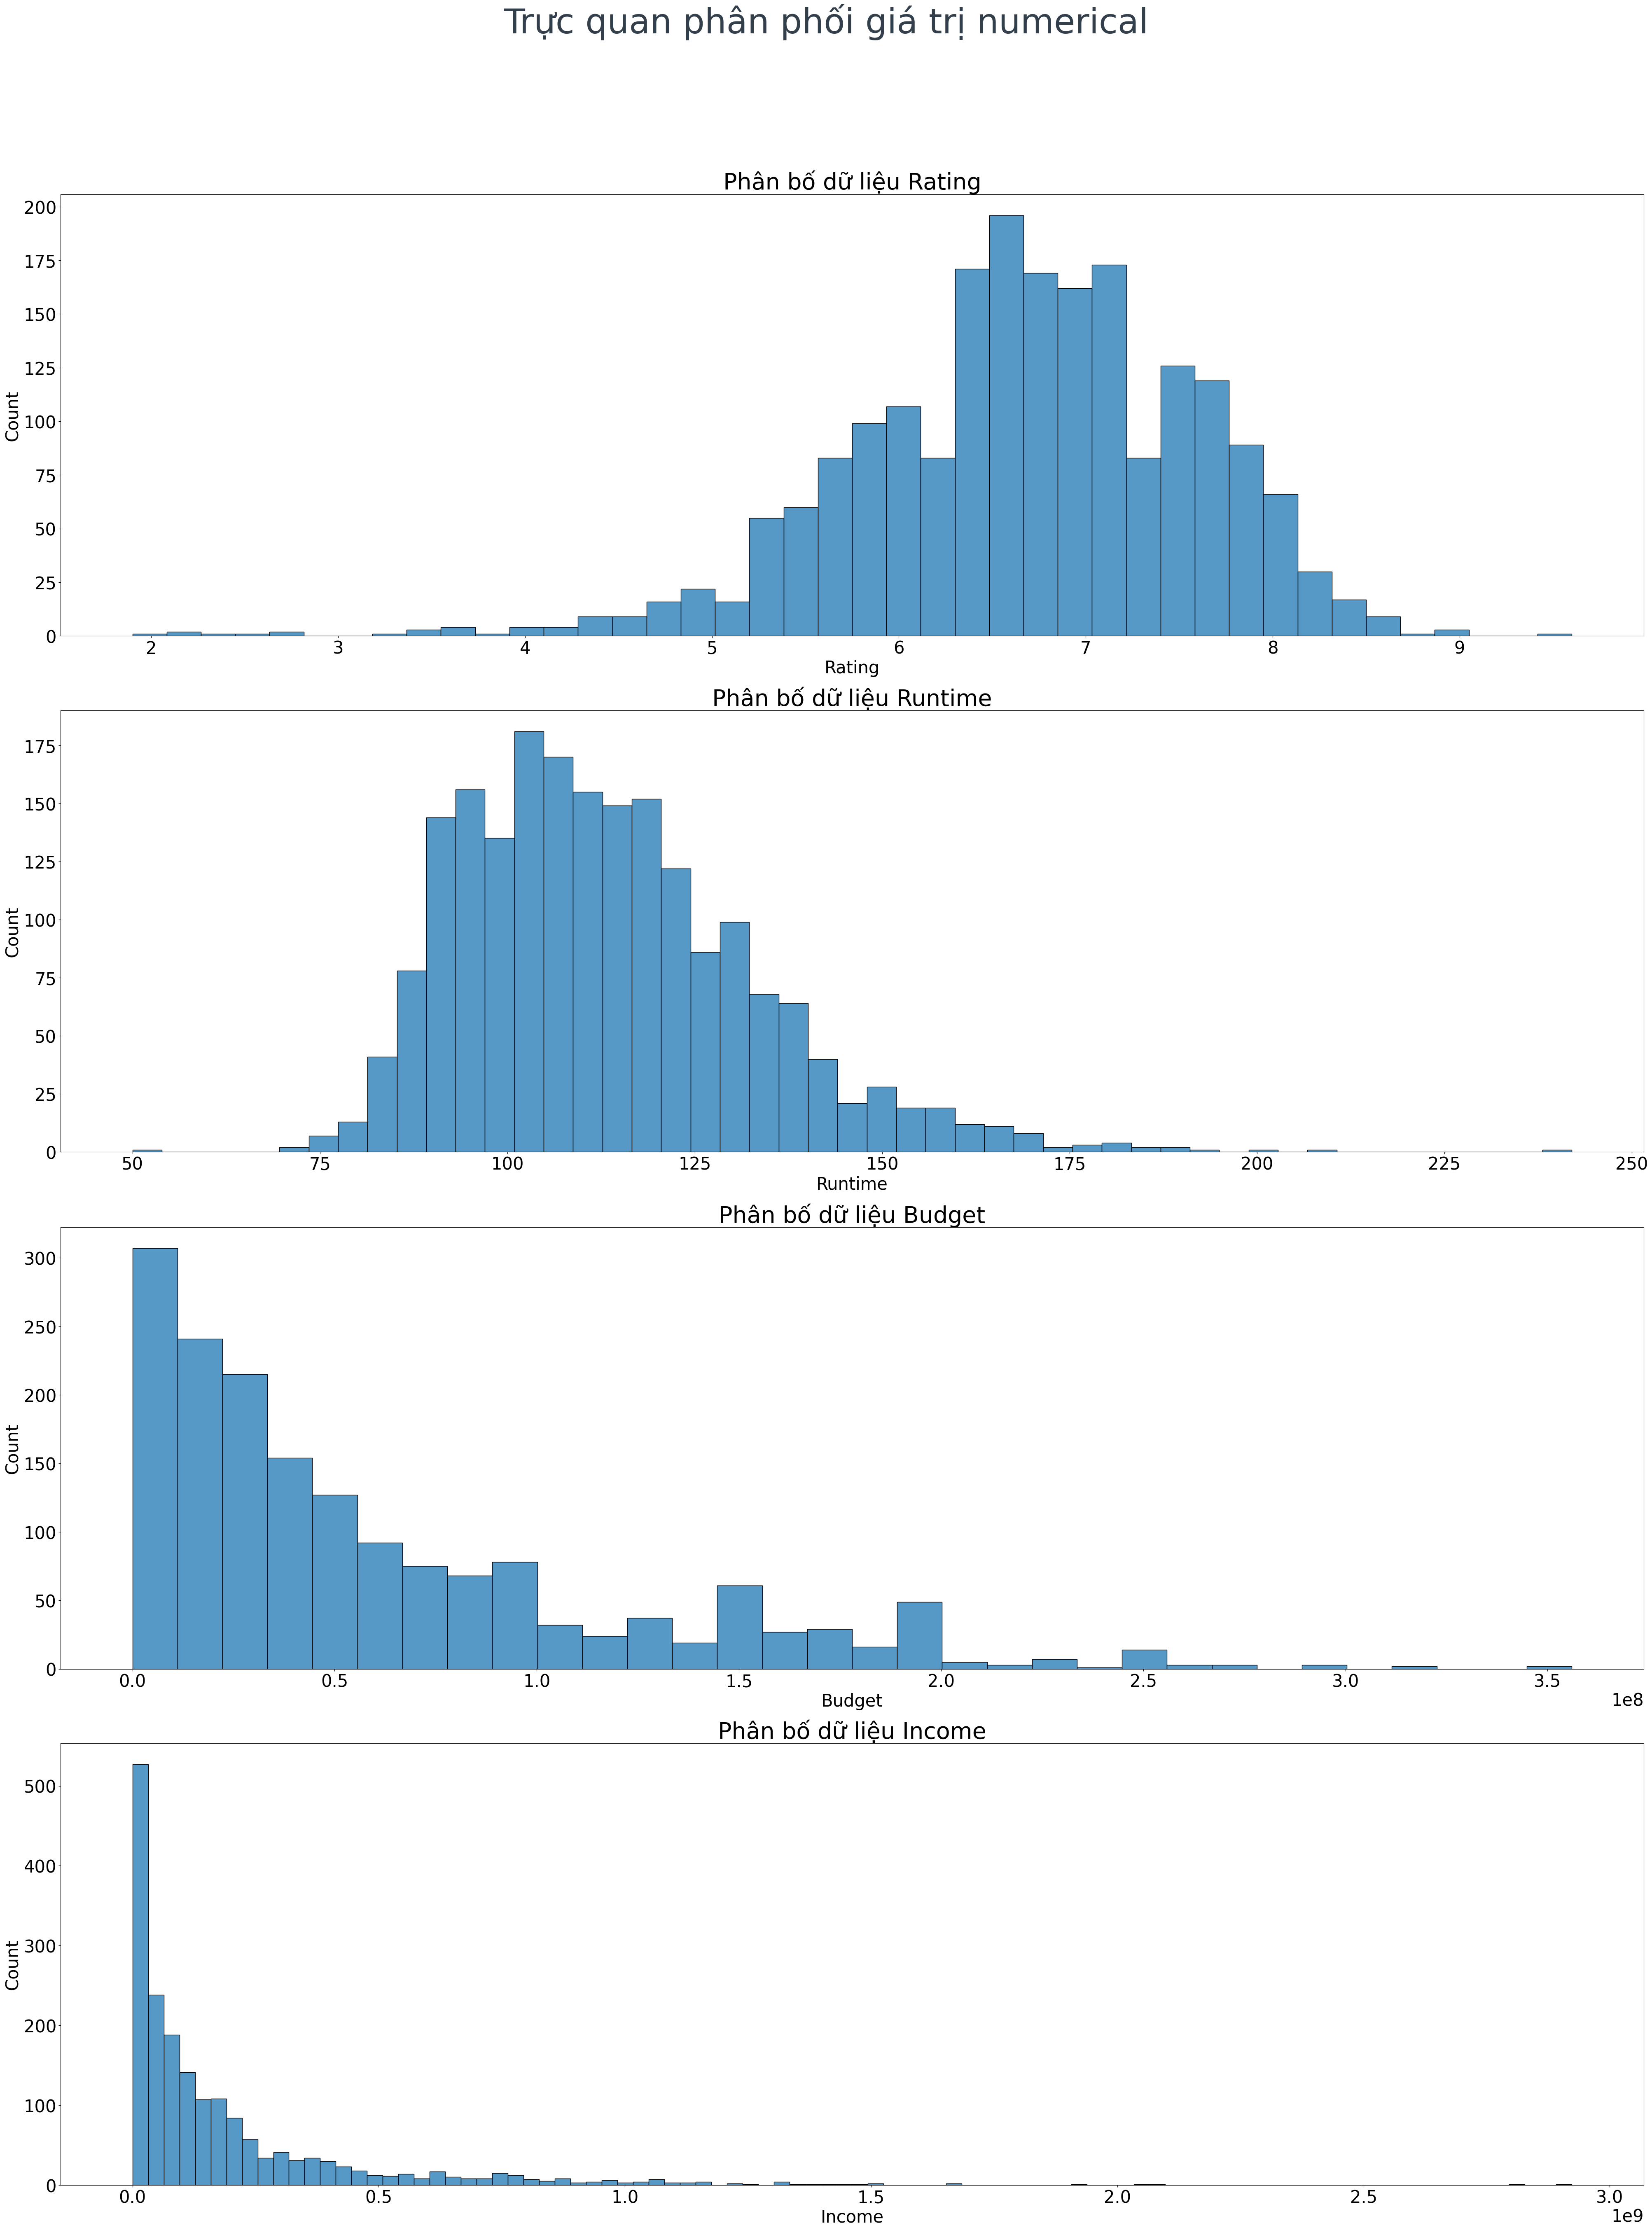

In [28]:
plt.rcParams['figure.figsize'] = 40, 50
fig , axs = plt.subplots(4, 1, constrained_layout = True)

idx = 0
while idx < numerical_df.shape[1]:
    r = idx 
    sns.histplot(x = numerical_df.iloc[:,idx], ax = axs[r])
    axs[r].set_title(f'Phân bố dữ liệu {numerical_df.columns[idx]}', fontsize = 40)
    axs[r].tick_params(axis='both', labelsize=30)
    axs[r].xaxis.get_offset_text().set_fontsize(30)
    axs[r].set_xlabel(str(numerical_df.columns[idx]), fontsize=30)
    axs[r].set_ylabel("Count", fontsize=30)
    idx += 1

plt.suptitle('Trực quan phân phối giá trị numerical', fontsize=60, y=1.08, color = '#333F4B')
plt.show();

**Nhận xét**
- Các trường thuộc tính **`Rating` và `Runtime`** gần với phân phối chuẩn.
- Các trường thuộc tính **`Budget`,`Income` thì bị lệch phải khá nhiều. Cần phải phân tích thêm.

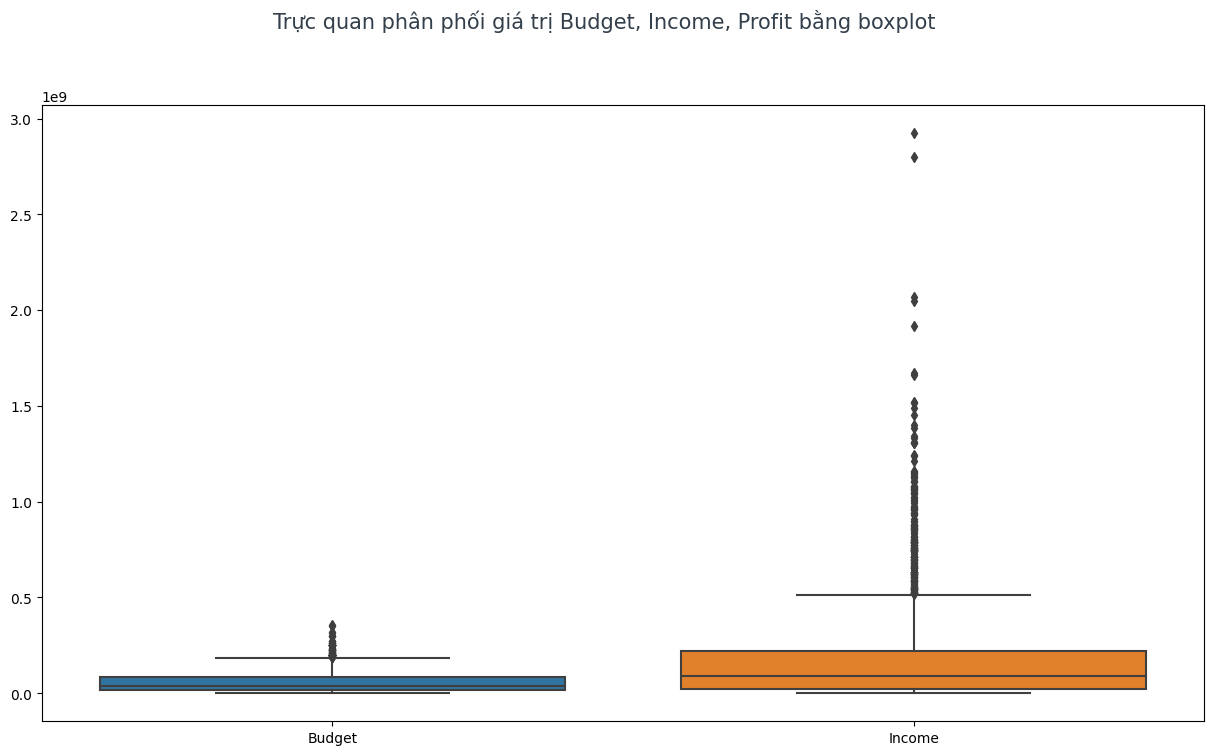

In [29]:
plt.rcParams['figure.figsize'] = 15, 8
sns.boxplot(data=movie_df[['Budget', 'Income']])
plt.suptitle('Trực quan phân phối giá trị Budget, Income, Profit bằng boxplot', 
             fontsize=15, 
             y=1, 
             color = '#333F4B')
plt.show();

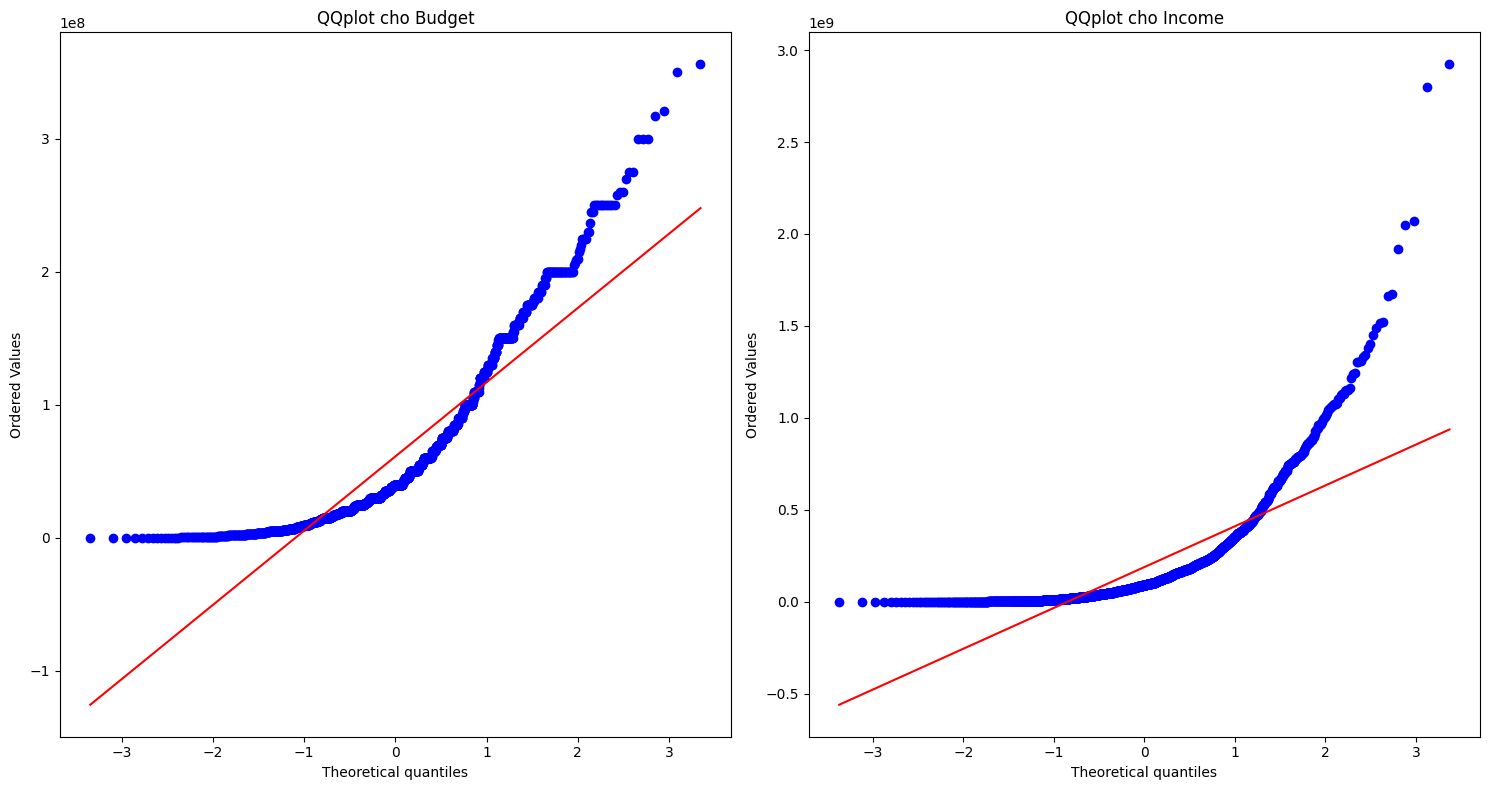

In [30]:
# Tạo subplot 1
plt.subplot(1, 2, 1)
stats.probplot(movie_df['Budget'].dropna(), plot=plt)
plt.title('QQplot cho Budget')

# Tạo subplot 2
plt.subplot(1, 2, 2)
stats.probplot(movie_df['Income'].dropna(), plot=plt)
plt.title('QQplot cho Income')

plt.tight_layout()
plt.show()

Qua 2 biểu đồ trên, ta có thể thấy được:
- Budget có phân phối chuẩn hơn so với Income, có vẻ Income có sự biến động nhiều hơn.
- Có nhiều giá trị ở Income gấp nhiều lần so với phần lớn, ngược lại với Budget, các giá trị lớn của nó tập trung gần với số lượng quantile 75%.

### 4.5 Thống kê dữ liệu categorical

In [31]:
movie_df[['Month', 'Certificate', 'Filming_location']].agg([missing_ratio,pd.Series.unique,pd.Series.nunique])

,Month,Certificate,Filming_location
missing_ratio,0.00,1.70,3.80
unique,"[December, August, November, January, October, March, September, May, April, July, June, February]","[PG-13, PG, R, TV-14, TV-MA, TV-PG, TV-Y7, Not Rated, nan, NC-17, TV-G, Unrated, G]","[New Zealand, USA, Japan, Ireland, nan, Canada, UK, Norway, Greece, Mexico, Spain, Italy, Bulgaria, Australia, Iceland, Belgium, Germany, Turkey, South Africa, France, South Korea, India, Egypt, A..."
nunique,12,12,96


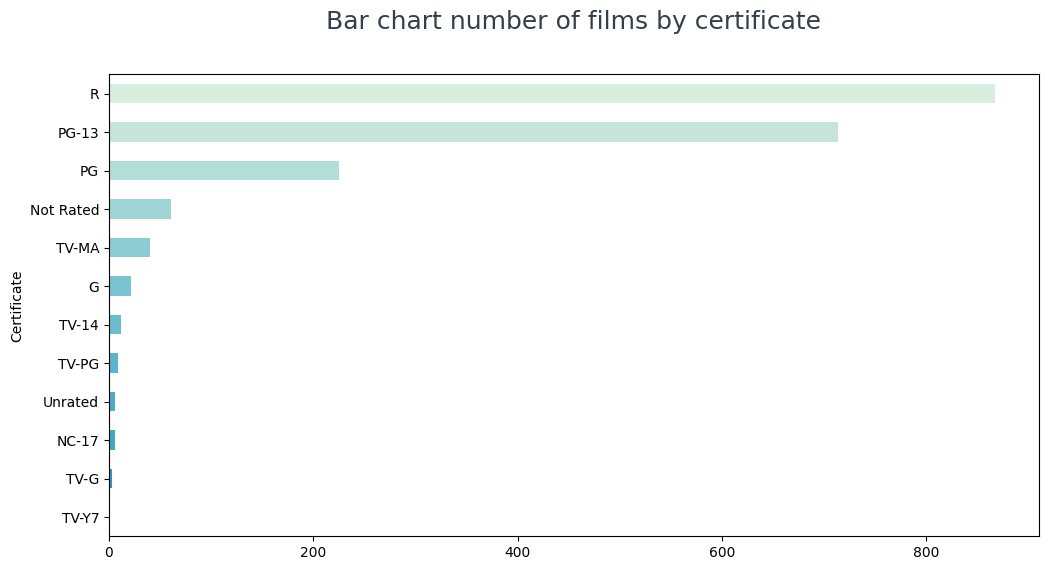

In [32]:
plt.rcParams['figure.figsize'] = 12,6
colors = [
    "#2c7bb6",
    "#3297bc",
    "#3fa9c1",
    "#4fabc7",
    "#5bb5cc",
    "#6bbcce",
    "#7ac4d1",
    "#8cccd4",
    "#9fd5d6",
    "#b2ddd9",
    "#c5e5db",
    "#d8eede"
]
movie_df['Certificate'].value_counts(ascending=True).plot.barh(color=colors)
plt.title('Bar chart number of films by certificate', fontsize=18, y=1.08, color = '#333F4B');

**Nhận xét**
- Đa số các phim có chứng chỉ thuộc về R (trên 17 tuổi) và PG-13 (trên 13 tuổi) với số lượng áp đảo. Tiếp theo sau là PG và Not Rated.

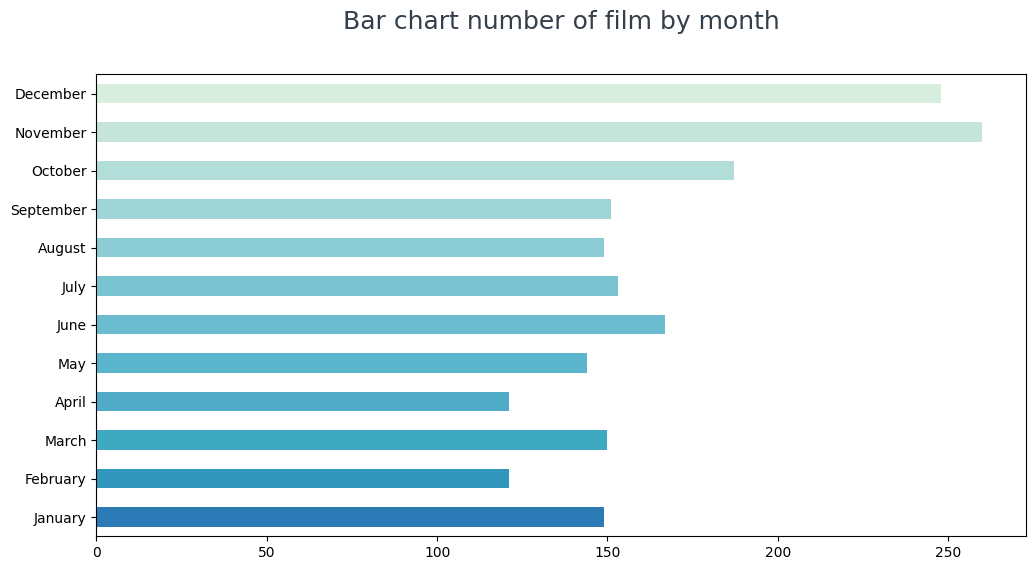

In [33]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']
pd.Categorical(movie_df['Month'], categories=month_order, ordered=True).sort_values().value_counts().plot.barh(color=colors)
plt.title('Bar chart number of film by month', fontsize=18, y=1.08, color = '#333F4B');

**Nhận xét**
- Đa số các phim có phát hành vào khoảng thời gian cuối năm từ tháng 10 đến tháng 12. Các tháng còn lại thì chênh lệch không đáng kể với nhau

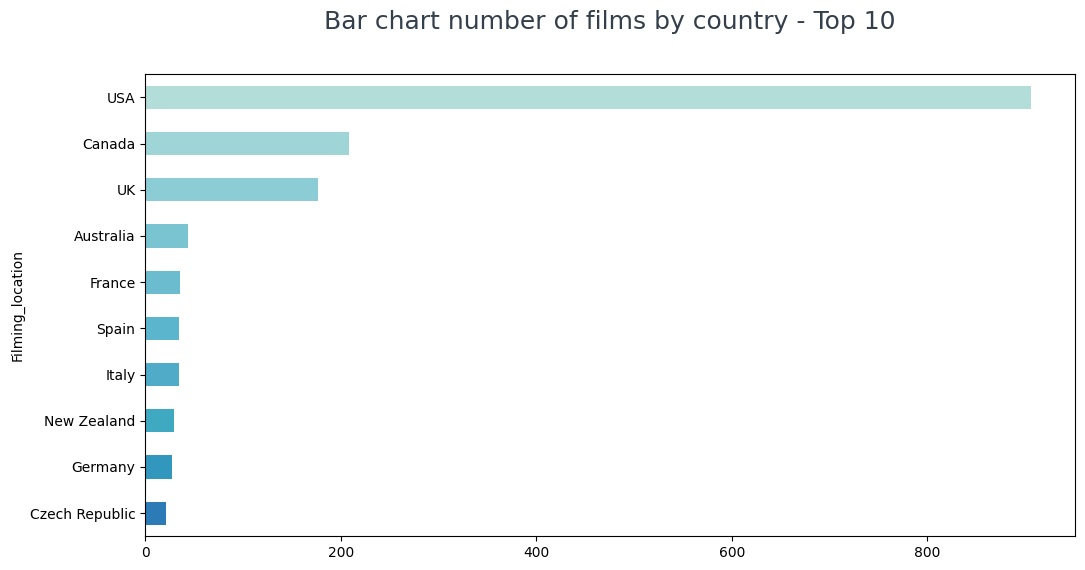

In [34]:
movie_df['Filming_location'].value_counts(ascending=True).tail(10).plot.barh(color=colors[:10])
plt.title('Bar chart number of films by country - Top 10', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Đa số các phim phổ biến ở được quay hình ở USA với số lượng áp đảo. Tiếp theo sau là các nước Canada và UK cũng khá nhiều bộ phim nổi bật hơn so với các quốc gia còn lại.</span>

<span style="font-size:18px;font-family: Times New Roman;">**Tiền xử lý trường thuộc Genre, Directors, Stars, Country_of_origin** </span>  

In [35]:
movie_df['Genre'] = movie_df['Genre'].apply(lambda x: [i.strip() for i in x.split(',')])
movie_df['Directors'] = movie_df['Directors'].apply(lambda x: [i.strip() for i in x.split(',')])
movie_df['Stars'] = movie_df['Stars'].apply(lambda x: [i.strip() for i in x.split(',')])
movie_df['Country_of_origin'] = movie_df['Country_of_origin'].apply(lambda x: [i.strip() for i in x.split(',')])

<span style="font-size:18px;font-family: Times New Roman;">**Thống kê dữ liệu trường thuộc Genre, Directors, Stars, Country_of_origin** </span> 

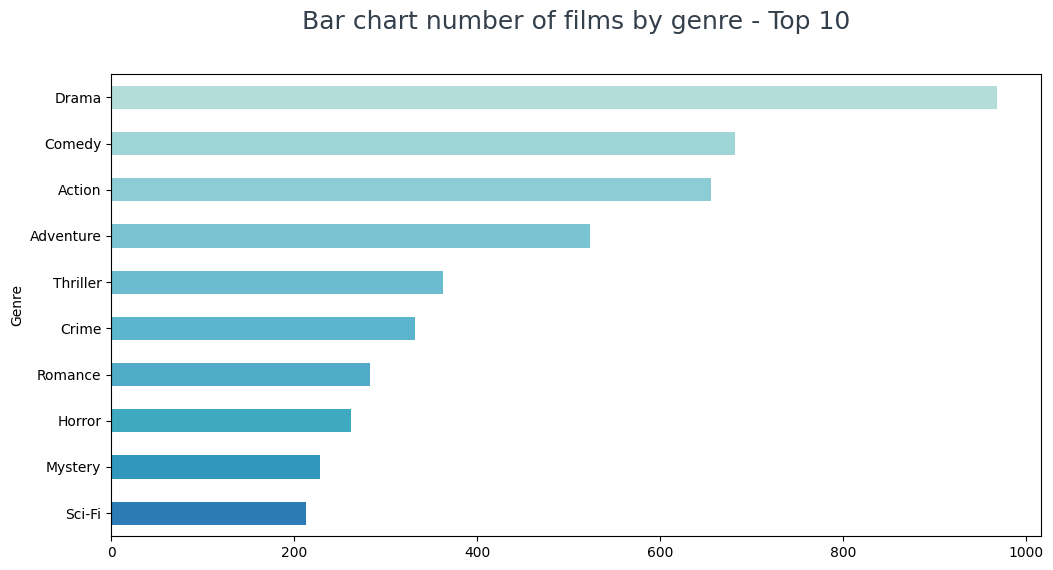

In [36]:
plt.rcParams['figure.figsize'] = 12,6
movie_df.explode('Genre')['Genre'].value_counts(ascending=True).tail(10).plot.barh(color=colors[:10])
plt.title('Bar chart number of films by genre - Top 10', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 thể loại phim thì phổ biến nhất là **Drama**, các thể loại phim như **Comedy, Action, Adventure** cũng chiếm số lượng lớn. </span>
- <span style="font-size:17px;font-family: Times New Roman;">Các thể loại còn lại trong danh sách cũng chiếm số lượng tương đối và không chênh lệch nhau đáng kể </span>

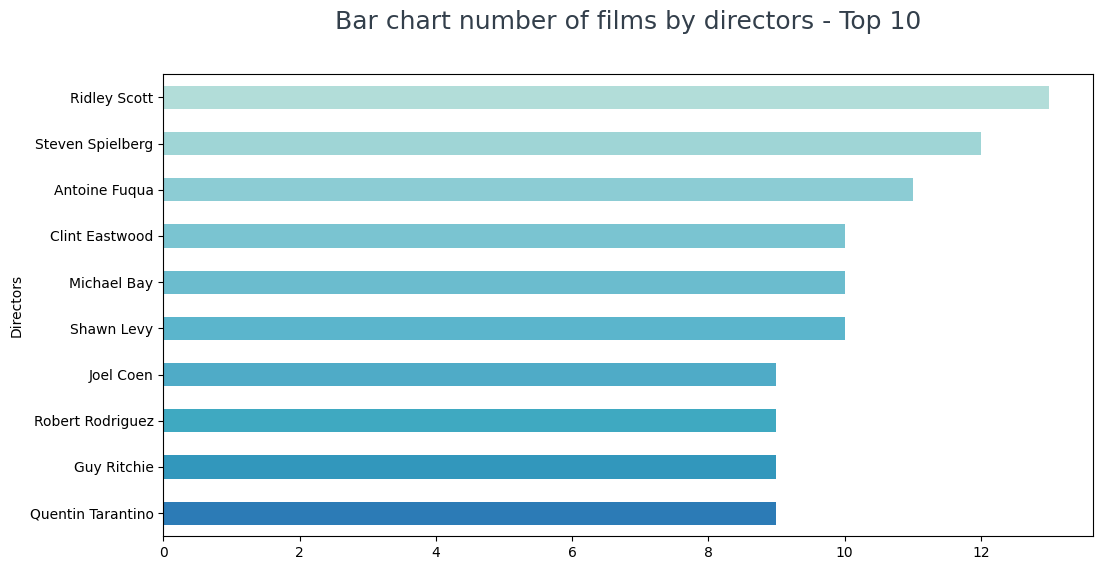

In [37]:
movie_df.explode('Directors')['Directors'].value_counts(ascending=True).tail(10).plot.barh(color=colors[:10])
plt.title('Bar chart number of films by directors - Top 10', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 đạo diễn có số lượng phim cao nhất thì nổi bật hơn là đạo diễn **Ridley Scott** </span>

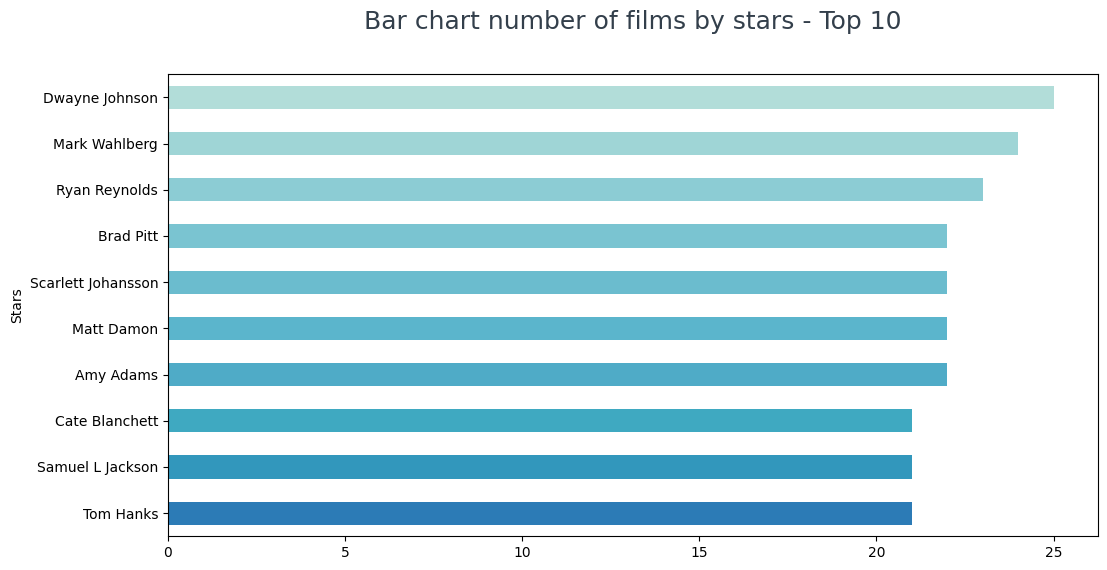

In [38]:
plt.rcParams['figure.figsize'] = 12,6
movie_df.explode('Stars')['Stars'].value_counts(ascending=True).tail(10).plot.barh(color=colors[:10])
plt.title('Bar chart number of films by stars - Top 10', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 diễn viên tham gia nhiều phim nhất thì nổi bật hơn là các diễn viên **Dwayne Johnson, Mark Wahlberg, Ryan Reynolds**.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Các diễn viên còn lại trong danh sách có số lượng chênh lệch quá đáng kể so với các diễn viên trên.</span>

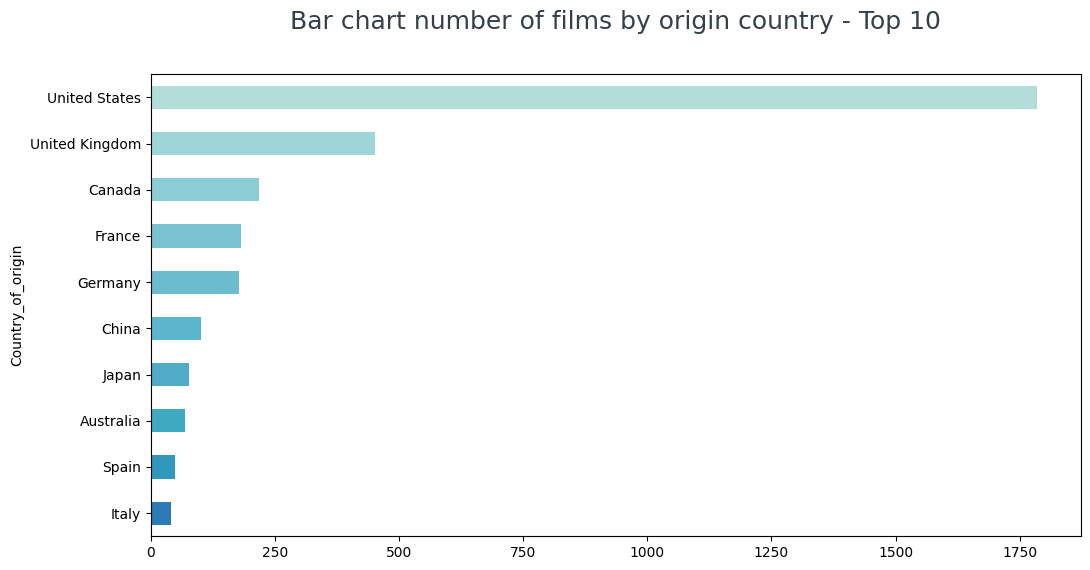

In [39]:
plt.rcParams['figure.figsize'] = 12,6
movie_df.explode('Country_of_origin')['Country_of_origin'].value_counts(ascending=True).tail(10).plot.barh(color=colors[:10])
plt.title('Bar chart number of films by origin country - Top 10', fontsize=18, y=1.08, color = '#333F4B');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 quốc gia tham gia sản xuất phim thì **USA** lại chiếm số lượng áp đảo. Tiếp theo vẫn là các quốc gia **Canada, UK, France, Germany**.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Các quốc gia còn lại thì số lương chênh nhau không đáng kể nhưng khá thấp so với các quốc gia ở trên.</span>

Qua các thống kê phân bố trên. Nhóm không phát hiện ra điều gì bất thường với dữ liệu categorical.

# 5 Phân tích tương quan & kiểm định giả thuyết

**Budget và Income**

In [40]:
X = movie_df[['Budget', 'Income']].dropna()['Budget']
y = movie_df[['Budget', 'Income']].dropna()['Income']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     1951.
Date:                Sun, 07 May 2023   Prob (F-statistic):          9.93e-282
Time:                        21:45:32   Log-Likelihood:                -33783.
No. Observations:                1649   AIC:                         6.757e+04
Df Residuals:                    1647   BIC:                         6.758e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.218e+06   6.71e+06     -0.331      0.7

### Nhận xét:
- Giá trị p cho hệ số Budget (0.000) cho thấy rằng hệ số là có ý nghĩa thống kê và quan hệ là nhân quả. Tức là, có một mối liên hệ tuyến tính giữa Budget và Income, với mỗi đơn vị tăng của Budget thì Income sẽ tăng thêm 3.4226 đơn vị (đơn vị tương ứng với đơn vị đo lường của Budget). 
- Tuy nhiên giá trị p của const lại cao(0.745), chứng tỏ mô hình này không có ý nghĩa về mặt thống kê.
- Tuy nhiên, cần lưu ý rằng mô hình chỉ giải thích được 54.2% sự biến thiên của Income, có thể còn có những yếu tố khác ảnh hưởng đến doanh thu của bộ phim.

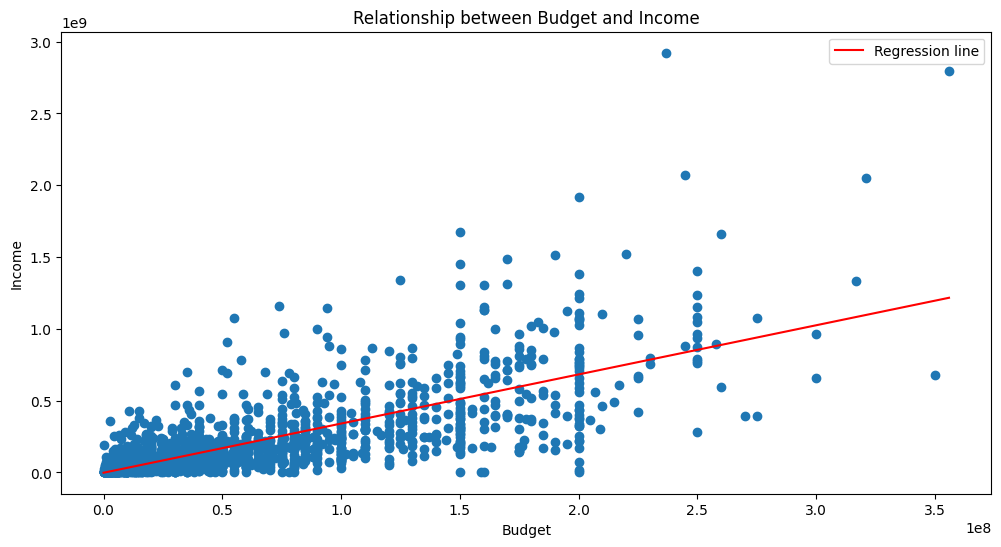

In [41]:
bud_in = movie_df[['Budget', 'Income']].dropna()
plt.scatter(bud_in.Budget, bud_in.Income)
x = np.linspace(0, bud_in.Budget.max(), 100)
y = 3.4226 * x - 2.183e+06
plt.plot(x, y, '-r', label='Regression line')
plt.xlabel('Budget')
plt.ylabel('Income')
plt.title('Relationship between Budget and Income')
plt.legend()
plt.show()

**Rating và Income**

In [42]:
X = movie_df[['Rating', 'Income']].dropna()['Rating']
y = movie_df[['Rating', 'Income']].dropna()['Income']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     63.13
Date:                Sun, 07 May 2023   Prob (F-statistic):           3.32e-15
Time:                        21:45:33   Log-Likelihood:                -38617.
No. Observations:                1854   AIC:                         7.724e+04
Df Residuals:                    1852   BIC:                         7.725e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.852e+08   4.74e+07     -3.911      0.0

### Nhận xét: 
- Nhìn vào kết quả phân tích hồi quy tuyến tính OLS, ta thấy rằng hệ số R-squared là 0.033, cho thấy mô hình chỉ giải thích được khoảng 3.3% sự biến động của biến phụ thuộc Income. Điều này có nghĩa là mô hình không phù hợp để dự đoán thu nhập của bộ phim dựa trên biến độc lập Rating.

- Ngoài ra, p-value của hệ số Rating là rất thấp (P<0.001), cho thấy rằng hệ số này là có ý nghĩa thống kê. Tuy nhiên, giá trị hệ số Rating là 5.565e+07, có thể hiểu là một đơn vị tăng trung bình của Rating sẽ dẫn đến tăng trung bình 5.565e+07 đơn vị của Income. Điều này có thể khó hiểu và không thực tế.

- Vì vậy, ta có thể kết luận rằng mô hình này không phù hợp để dự đoán thu nhập của bộ phim dựa trên biến độc lập Rating. Cần phải xem xét thêm các biến độc lập khác để tạo ra mô hình dự đoán chính xác hơn.

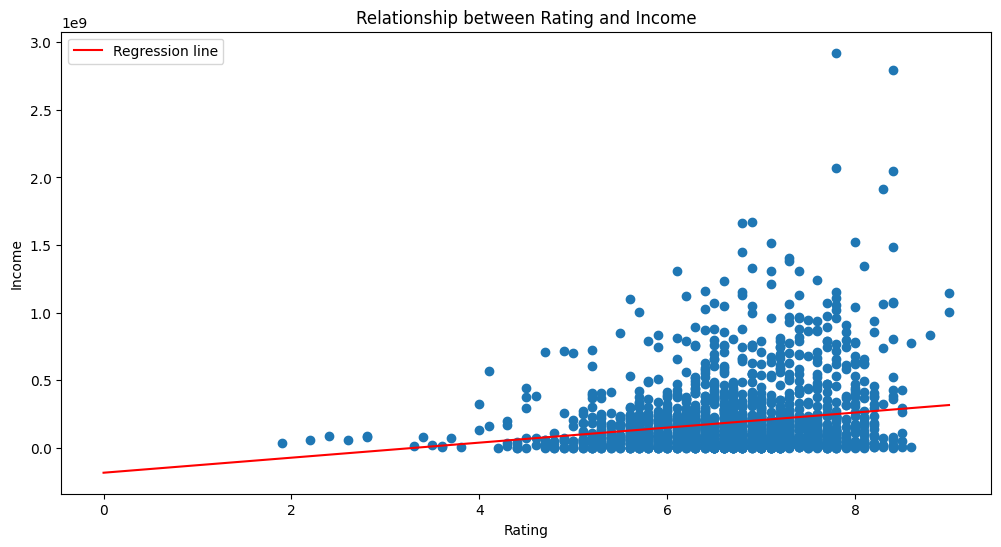

In [43]:
ra_in = movie_df[['Rating', 'Income']].dropna()
plt.scatter(ra_in.Rating, ra_in.Income)
x = np.linspace(0, ra_in.Rating.max(), 100)
y = 5.565e+07 * x -1.852e+08
plt.plot(x, y, '-r', label='Regression line')
plt.xlabel('Rating')
plt.ylabel('Income')
plt.title('Relationship between Rating and Income')
plt.legend()
plt.show()

In [44]:
X = movie_df[['Rating', 'Budget', 'Income']].dropna()[['Rating', 'Budget']]
y = movie_df[['Rating', 'Budget', 'Income']].dropna()['Income']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     1106.
Date:                Sun, 07 May 2023   Prob (F-statistic):          4.05e-305
Time:                        21:45:33   Log-Likelihood:                -33725.
No. Observations:                1649   AIC:                         6.746e+04
Df Residuals:                    1646   BIC:                         6.747e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.788e+08    3.5e+07    -10.824      0.0

Nhìn vào kết quả phân tích hồi quy tuyến tính OLS, ta thấy rằng hệ số R-squared đã được cải thiện đáng kể lên đến 0.573, cho thấy mô hình giải thích được khoảng 57.3% sự biến động của biến phụ thuộc Income. Điều này chứng tỏ mô hình này phù hợp hơn để dự đoán thu nhập của bộ phim dựa trên các biến độc lập Rating và Budget.

Cả hai hệ số Rating và Budget đều có p-value rất thấp (P<0.001), cho thấy rằng cả hai đều có ý nghĩa thống kê. Hệ số Rating là 5.61e+07, có thể hiểu là một đơn vị tăng trung bình của Rating sẽ dẫn đến tăng trung bình 5.61e+07 đơn vị của Income. Hệ số Budget là 3.4164, có thể hiểu là một đơn vị tăng trung bình của Budget sẽ dẫn đến tăng trung bình 3.4164 đơn vị của Income.

Tuy nhiên, chú ý đến giá trị của Condition Number, với giá trị lớn là 6.74e+08, có thể cho thấy sự tương quan mạnh giữa các biến độc lập và tiềm tàng vấn đề về đa cộng tuyến. Do đó, cần kiểm tra mối quan hệ giữa các biến độc lập và đảm bảo rằng không có vấn đề về đa cộng tuyến trước khi sử dụng mô hình để dự đoán Income.

Nhóm sẽ chọn 2 đặc trưng là **Rating** và **Budget** để xây dựng mô hình dự đoán **Income** của một bộ phim 

# 6. Xử lý dữ liệu

In [105]:
feature_df = movie_df.drop(columns = 'Income')
target_df = movie_df[['Income']]

In [74]:
feature_df.isna().sum(axis = 0)

Title                  0
Rating                 0
Year                   0
Month                  0
Certificate           16
Runtime                0
Directors              0
Stars                  0
Genre                  0
Filming_location      62
Budget               205
Country_of_origin      0
dtype: int64

## 6.1 Xử lí NaN
- Rating, Runtime và Budge sẽ thay giá trị NaN bằng mean
- Các thông tin như Certificate sẽ thay giá trị NaN bằng mode, riêng giá trị Filming_location sẽ thay thế bằng Country_film_location

In [91]:
def fillna_location(row):
    if pd.isnull(row['Filming_location']) == False:
        row['Filming_location'] = [row['Filming_location']]
        return row
    row['Filming_location'] = row['Country_of_origin'].copy()
    return row

In [106]:
feature_df['Rating'].fillna(feature_df['Rating'].mean(), inplace=True)
feature_df['Runtime'].fillna(feature_df['Runtime'].mean(), inplace=True)
feature_df['Budget'].fillna(feature_df['Budget'].mean(), inplace=True)
feature_df['Certificate'].fillna(feature_df['Certificate'].mode().values[0], inplace=True)
feature_df = feature_df.apply(lambda x: fillna_location(x), axis = 1)

In [93]:
feature_df.isna().sum(axis = 0)

Title                0
Rating               0
Year                 0
Month                0
Certificate          0
Runtime              0
Directors            0
Stars                0
Genre                0
Filming_location     0
Budget               0
Country_of_origin    0
dtype: int64

## 6.2 Scaling numerical features

In [107]:
minmax_scale = MinMaxScaler()
scale_df = pd.DataFrame(minmax_scale.fit_transform(feature_df[["Rating", "Year",
                                                               "Runtime", "Budget"]]), 
                                                   columns = ["Rating", "Year",
                                                              "Runtime", "Budget"] )

## 6.3 Onehot category features
- Đối với các cột Month, Certificate và Director (chỉ chứa một giá trị) thì nhóm sẽ dùng Onehot Encode
- Đối với các cột Directors, Stars, Genre, Filming_location, Country_of_origin thì giá trị dạng list nên nhóm sẽ dùng MultiLabel Binarizer.

In [108]:
category_columns = ['Month', 'Certificate', 'Directors', 
                    'Stars', 'Genre', 'Filming_location',
                    'Country_of_origin']

onehot_df = pd.DataFrame()

for column in category_columns:
    if column in ['Month', 'Certificate']:
        onehot_encode = OneHotEncoder(sparse=False)
        onehot_df = pd.concat((onehot_df, pd.DataFrame(onehot_encode.fit_transform(feature_df[[column]]),
                                                       columns = onehot_encode.get_feature_names_out())),
                               axis = 1)
    else:   
        multiple_encode = MultiLabelBinarizer()
        multiple_encode.fit(feature_df[column])
        onehot_df = pd.concat((onehot_df,pd.DataFrame(multiple_encode.transform(feature_df[column]), 
                                                     columns=[column + "_" + value for value in multiple_encode.classes_])), 
                              axis = 1)
    

In [113]:
transform_feature_df = pd.concat((scale_df, onehot_df), axis = 1)
transform_feature_df.head()

,Rating,Year,Runtime,Budget,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,...,Country_of_origin_Sweden,Country_of_origin_Switzerland,Country_of_origin_Taiwan,Country_of_origin_Thailand,Country_of_origin_Tunisia,Country_of_origin_Turkey,Country_of_origin_United Arab Emirates,Country_of_origin_United Kingdom,Country_of_origin_United States,Country_of_origin_Uruguay
0,0.79,1.00,0.74,0.98,0.00,0.00,1.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,1,0
1,0.77,1.00,0.35,0.10,0.00,0.00,1.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,1,0
2,0.70,1.00,0.40,0.24,0.00,1.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,1,0
3,0.79,1.00,0.33,0.17,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,1,1,0
4,0.62,1.00,0.27,0.17,0.00,0.00,0.00,0.00,1.00,0.00,...,0,0,0,0,0,0,0,0,1,0


# 7. Huấn luyện mô hình 

## 7.1 Dùng hết tất cả feature
- Nhóm tách dữ liệu đã transform thành 2 phần:
    - Phần 1: Dữ liệu có Income sẽ chia thành 2 tập train và test
    - Phần 2: Dữ liệu không chưa Income để dự đoán

In [146]:
train_target_df = target_df[~target_df['Income'].isna()]
train_df = transform_feature_df.iloc[train_target_df.index]

predict_target_df = target_df[target_df['Income'].isna()]
predic_df = transform_feature_df.iloc[predict_target_df.index]

In [147]:
x_data_train, x_data_test, y_data_train, y_data_test = train_test_split(train_df, train_target_df,
                                                                        test_size=0.3,random_state=42)

In [148]:
lr_model = LinearRegression()

lr_model.fit(x_data_train, y_data_train)

y_pred = lr_model.predict(x_data_test)

rmse = mean_squared_error(y_data_test, y_pred, squared=False)
rmae = mean_absolute_error(y_data_test, y_pred)
r2 = r2_score(y_data_test, y_pred)

print("MSE:", rmse)
print("MAE:", rmae)
print("R2 Score:", r2)

MSE: 256111772.47901785
MAE: 176582973.75054345
R2 Score: 0.19007908462873024


### Nhận xét:
- Kết quả RMSE là 256.111.772$, hiện tại độ lỗi của mô hình khá cao.
- R2 Score chỉ đạt 0.19, tức là mô hình chỉ giải thích được 19% sự biến thiên của dữ liệu. Mô hình này chưa tốt nên nhóm sẽ cải tiến.

## 7.2 Chỉ dùng các feature có tương quan cao

In [149]:
esstial_feature_df = train_df[['Rating', 'Budget']]

In [150]:
x_data_train, x_data_test, y_data_train, y_data_test = train_test_split(esstial_feature_df, train_target_df,test_size=0.2,random_state=42)

In [151]:
lr_model = LinearRegression()

lr_model.fit(x_data_train, y_data_train)

y_pred = lr_model.predict(x_data_test)

rmse = mean_squared_error(y_data_test, y_pred, squared=False)
rmae = mean_absolute_error(y_data_test, y_pred)
r2 = r2_score(y_data_test, y_pred)

print("MSE:", rmse)
print("MAE:", rmae)
print("R2 Score:", r2)

MSE: 193228709.5796563
MAE: 124672988.96580343
R2 Score: 0.562434399143394


### Nhận xét:
- Kết quả RMSE là 193.224.625 $, dù độ lỗi của mô hình vẫn còn cao đã giảm đáng kể so với trước đó và nếu nhìn tổng thể thì con số này không đáng kể so với doanh thu của nhiều bộ phim thuộc hàng top.
- R2 Score tăng lên đạt 0.5625, tức là mô hình chỉ giải thích được 56.24% sự biến thiên của dữ liệu. Dù chưa quá cao nhưng với số lượng mẫu hạn chế thì mô hình trên cũng khá tốt. Có thể tăng mẫu để cải thiện mô hình giúp tăng độ chính xác và độ giải thích của nó.